In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akram24/google-stock-price-train")

print("Path to dataset files:", path)

100%|██████████| 22.8k/22.8k [00:00<00:00, 26.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/akram24/google-stock-price-train/versions/1


In [ ]:
# Load Google stock price dataset
data = pd.read_csv('GOOG.csv',thousands=',')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [ ]:
data = data[["Close"]]

In [ ]:
data.dropna(inplace=True)

<ipython-input-9-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [ ]:
def create_sequences(data, sequence_length):
    X, Y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [ ]:
sequence_length = 60
X, Y = create_sequences(data_scaled, sequence_length)

In [ ]:
# Reshape input to be 3D for RNN [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

In [ ]:
model = keras.Sequential([
    layers.SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.SimpleRNN(50),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0082 - val_loss: 0.0016
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.0648e-04 - val_loss: 0.0011
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 9.2639e-05 - val_loss: 8.7731e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6.7879e-05 - val_loss: 9.5156e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.9934e-05 - val_loss: 6.1803e-04
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5.8572e-05 - val_loss: 6.2152e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 5.1474e-05 - val_loss: 6.5144e-04
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.2206e-05 - val_loss: 5.7290e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.9566e-05 - val_loss: 6.5566e-04
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.7381e-05 - val_loss: 1.6436e-04
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.9367e-05 - val_loss

In [ ]:
loss = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.8339e-04
Test Loss: 0.0012


In [ ]:
# Predict
predicted_stock_price = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

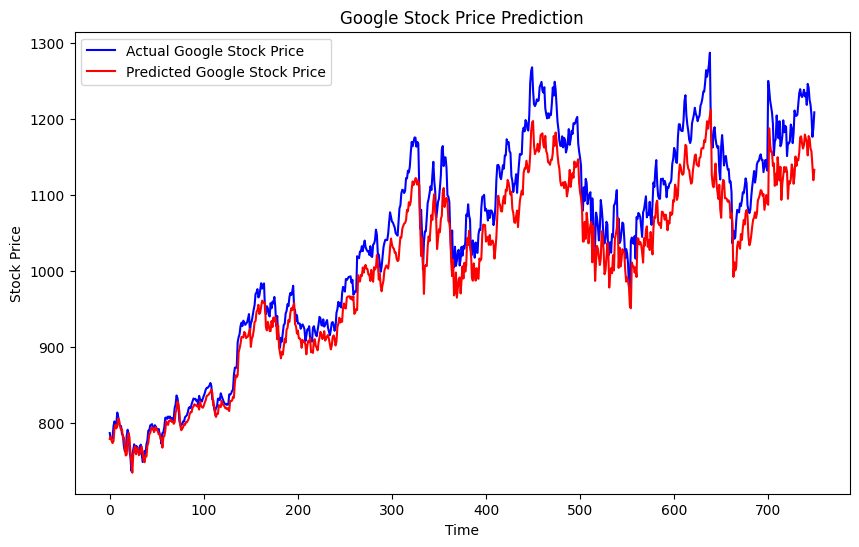

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Google Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
